In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [2]:
def count_files_in_folders(folder_path):
    # Initialize counters
    total_files = 0

    # Walk through the folder and its subfolders
    for root, dirs, files in os.walk(folder_path):
        # Count files in the current folder
        files_count = len(files)
        total_files += files_count

        # Display the result for the current folder
        print(f"Folder: {root}, Files: {files_count}")

    # Display the total count
    print(f"\nTotal Files in {folder_path}: {total_files}")

# the path to analyze
folder_path = '/content/drive/MyDrive/Train_Ready'
count_files_in_folders(folder_path)


Folder: /content/drive/MyDrive/Train_Ready, Files: 0
Folder: /content/drive/MyDrive/Train_Ready/train, Files: 0
Folder: /content/drive/MyDrive/Train_Ready/train/healthy, Files: 1214
Folder: /content/drive/MyDrive/Train_Ready/train/leaf_blight, Files: 1222
Folder: /content/drive/MyDrive/Train_Ready/train/yellow_mottle_virus, Files: 1220
Folder: /content/drive/MyDrive/Train_Ready/validation, Files: 0
Folder: /content/drive/MyDrive/Train_Ready/validation/healthy, Files: 260
Folder: /content/drive/MyDrive/Train_Ready/validation/leaf_blight, Files: 262
Folder: /content/drive/MyDrive/Train_Ready/validation/yellow_mottle_virus, Files: 261
Folder: /content/drive/MyDrive/Train_Ready/test, Files: 0
Folder: /content/drive/MyDrive/Train_Ready/test/healthy, Files: 261
Folder: /content/drive/MyDrive/Train_Ready/test/leaf_blight, Files: 263
Folder: /content/drive/MyDrive/Train_Ready/test/yellow_mottle_virus, Files: 263

Total Files in /content/drive/MyDrive/Train_Ready: 5226


In [5]:
train_path = "/content/drive/MyDrive/Train_Ready/train"
valid_path = "/content/drive/MyDrive/Train_Ready/validation"
test_path = "/content/drive/MyDrive/Train_Ready/test"

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=train_path, target_size=(224,224), classes=['healthy', 'leaf_blight', 'yellow_mottle_virus'], batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['healthy', 'leaf_blight', 'yellow_mottle_virus'], batch_size=32)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes=['healthy', 'leaf_blight', 'yellow_mottle_virus'], batch_size=32, shuffle=False)


Found 3656 images belonging to 3 classes.
Found 783 images belonging to 3 classes.
Found 787 images belonging to 3 classes.


In [10]:
imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

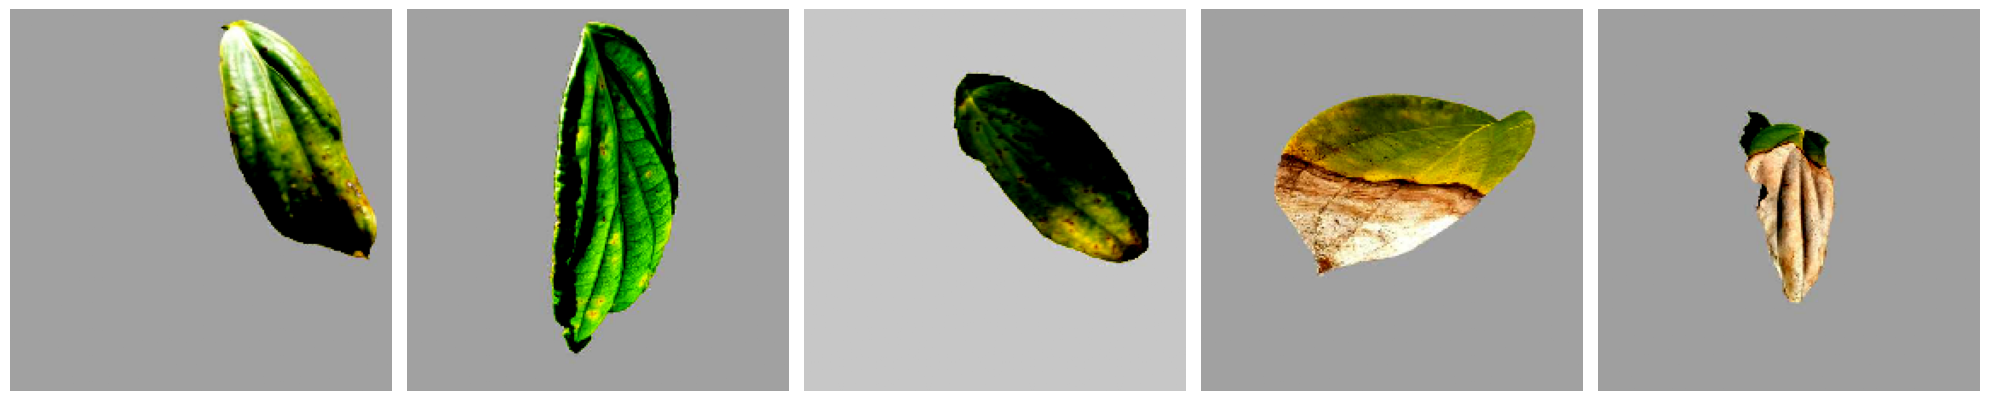

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [11]:
plotImages(imgs)
print(labels)

In [12]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [13]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [31]:
x = mobile.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = Dense(units=3, activation='softmax')(x)

In [32]:
model = Model(inputs=mobile.input, outputs=output)

In [33]:
for layer in model.layers[:-26]:
  layer.trainable=False

In [34]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [35]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [37]:
model_path = '/content/drive/MyDrive/Test2/Out/Models/model2.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [38]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=5,
  callbacks=callbacks_list
)

Epoch 1/5
115/115 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9683
Epoch 1: val_accuracy improved from -inf to 0.65900, saving model to /content/drive/MyDrive/Test2/Out/Models/model2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 816s 7s/step - loss: 0.0920 - accuracy: 0.9683 - val_loss: 1.4680 - val_accuracy: 0.6590
Epoch 2/5
115/115 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9967
Epoch 2: val_accuracy improved from 0.65900 to 0.99361, saving model to /content/drive/MyDrive/Test2/Out/Models/model2.h5
115/115 [==============================] - 307s 3s/step - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.0338 - val_accuracy: 0.9936
Epoch 3/5
115/115 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9997
Epoch 3: val_accuracy improved from 0.99361 to 0.99872, saving model to /content/drive/MyDrive/Test2/Out/Models/model2.h5
115/115 [==============================] - 323s 3s/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 4/5
115/115 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9997
Epoch 4: val_accuracy improved from 0.99872 to 1.00000, saving model to /co

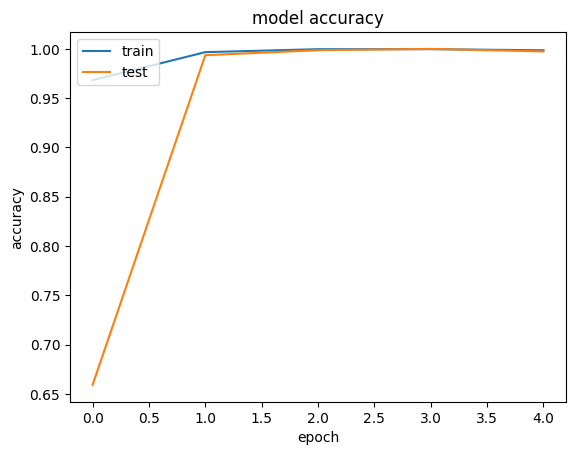

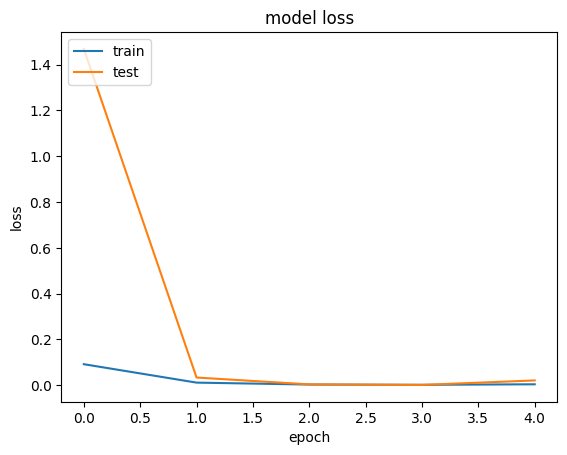

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
test_batches.class_indices

{'healthy': 0, 'leaf_blight': 1, 'yellow_mottle_virus': 2}

Confusion matrix, without normalization
[[259   2   0]
 [  0 263   0]
 [  0   1 262]]


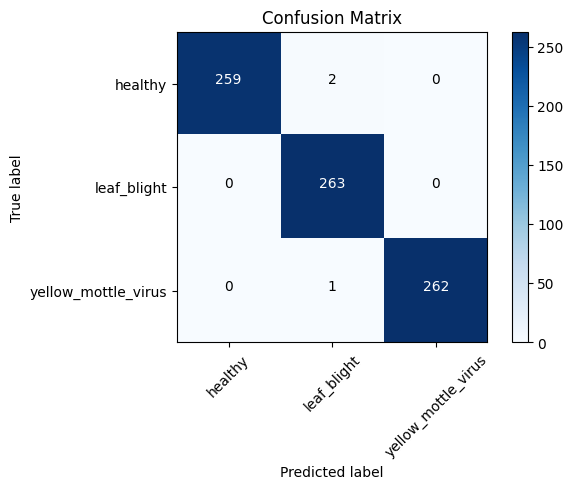

In [47]:
cm_plot_labels=['healthy', 'leaf_blight', 'yellow_mottle_virus']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [44]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_batches)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


25/25 [==============================] - 34s 1s/step - loss: 0.0251 - accuracy: 0.9962
Test Loss: 0.025095107033848763
Test Accuracy: 0.9961880445480347


In [48]:
from sklearn.metrics import classification_report

In [49]:
cr = classification_report(y_true=test_labels, y_pred=predictions.argmax(axis=1), target_names=cm_plot_labels)
print(cr)

                     precision    recall  f1-score   support

            healthy       1.00      0.99      1.00       261
        leaf_blight       0.99      1.00      0.99       263
yellow_mottle_virus       1.00      1.00      1.00       263

           accuracy                           1.00       787
          macro avg       1.00      1.00      1.00       787
       weighted avg       1.00      1.00      1.00       787



In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the saved model
model_path = '/content/drive/MyDrive/Test2/Out/Models/model2.h5'
model = tf.keras.models.load_model(model_path)

# Define the classes
classes = ['healthy', 'leaf_blight', 'yellow_mottle_virus']

# Function to preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict(image_path):
    img_array = preprocess_image(image_path)
    # Normalize the image data (MobileNet model was trained with normalized data)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    # Make prediction
    predictions = model.predict(img_array)
    # Get the predicted class index
    predicted_index = np.argmax(predictions, axis=1)[0]
    # Get the predicted class label
    predicted_class = classes[predicted_index]
    return predicted_class, predictions[0]

# Path to the image you want to make a prediction on
image_path = "/content/drive/MyDrive/Article_Generation/1.png"

# Make prediction
predicted_class, predictions = predict(image_path)
print("Result:", predicted_class)
#print("Predictions:", predictions)


1/1 [==============================] - 1s 596ms/step
Result: leaf_blight
